# How much money will the hospital save if they adopt the proposed prediction model?
Ideally, the model will be able to predict 100% of the patients that are going to be readmitted, thus saving the hospital on all readmission costs. However, in practice, higher recall (the ability of the model to identify readmitted patients) comes at the cost of low precision (the quality of predictions). Is it more important to identify as many patients that are going to be readmitted as possible even if it means including a lot of patients that will not actually be readmitted or identify fewer patients that will actually be readmitted if it means minimizing the number of wrong predictions? The answer is not immediately obvious without performing some calculations!

## Definitions
#### TP - a patient that is predicted to be readmitted and is actually readmitted
#### FP - a patient that is predicted to be readmitted but is not actually readmitted
#### TN - a patient that is predicted to not be readmitted and is actually not readmitted
#### FN - a patient that is predicted to be not readmitted and is actually readmitted

#### TPR (true positive rate) = TP / (TP+FN)
#### FPR (false positive rate) = FP / (TP+FP)

Since TP is the constant term in the TPR and FPR calculations, the distinguishing terms are FN and FP. Which means that whether TPR or FPR is more important depends on the relative cost of FP and FN patients. According to SpeechMed the cost of a readmitted patient (FN) on Medicare is ~ $18,000 (1), while Helathcatalist reports the average annual cost of care management programs is ~ 1,500 (2). Note that if a patient is flagged as likely to be readmitted, the hospital will enroll them into a care management program, thus this is a good estimate of FP patient cost. We will consider the annual cost to the hospital:

Model assumptions:
TP_cost = 0; 
TN_cost = 0; 
FP_cost = 1,500; 
FN_cost = 18,000

To make the model more realistic, let's say the hospital already employs a system for flagging patients for high risk of readmission - the HOSPITAL score (3).
TPR_HOSP = 0.6;
FPR_HOSP = 0.4


References
1. https://www.speechmed.com/cost-hospital-readmission/
2. https://www.healthcatalyst.com/care-management-reduces-costs-by-doing-the-right-thing
3. https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2727268

In [1]:
# Set up a model to sumulate hospital savings at different values of TPR and FPR
# First, calculate the savings with the current solution, the HOSPITAL score

import numpy as np
TP_cost = 0 
TN_cost = 0 
FP_cost = 1500 
FN_cost = 18000

# assign TPR and FPR values of the HOSPITAL score (from the paper cited in (3))
TPR_HOSP = 0.6
FPR_HOSP = 0.4

# assign TPR and FPR values for current best model (logistic regression C=0.01)
TPR_lr = 0.77
FPR_lr = 0.4

# let's assume there are a total of 1000 hospital admissions and 10% are readmitted
num_admissions = 1000
fract_readmitted = 0.1
num_readmitted = num_admissions*fract_readmitted
cost_wo_model = FN_cost*num_readmitted # this will be our basis of comparison

print("A hospital with 1000 annual admissions, 10% readmission rate and no readmission flagging system will spend ${}M on unplanned readmissions."\
      .format(cost_wo_model/10**6))

# calculate the cost if the hospital uses the HOSPITAL score flagging system
num_FP = FPR_HOSP*TPR_HOSP/(1-FPR_HOSP)*num_readmitted
num_FN = (1-TPR_HOSP)*num_readmitted
HOSP_total_cost = num_FN*FN_cost + num_FP*FP_cost 
print("If the same hospital utilizes the HOSPITAL score for flagging patients likely to be readmitted, their cost will be ${}M."\
      .format(HOSP_total_cost/10**6))

# calculate the savings with the HOSPITAL score
savings_wHOSP_score = (cost_wo_model-HOSP_total_cost)/cost_wo_model*100

print("Total savings to the hospital using the HOSPITAL score are {:.1f}%".format(savings_wHOSP_score))

# calculate the cost with current best model
num_FP = FPR_lr*TPR_lr/(1-FPR_lr)*num_readmitted
num_FN = (1-TPR_lr)*num_readmitted
lr_total_cost = num_FN*FN_cost + num_FP*FP_cost 
print("If the same hospital utilizes presented model for flagging patients likely to be readmitted, their cost will be ${}M."\
      .format(lr_total_cost/10**6))

# calculate the savings with the HOSPITAL score
savings_lr_score = (cost_wo_model-lr_total_cost)/cost_wo_model*100

print("Total savings to the hospital using the current model are {:.1f}%. Not bad!".format(savings_lr_score))

A hospital with 1000 annual admissions, 10% readmission rate and no readmission flagging system will spend $1.8M on unplanned readmissions.
If the same hospital utilizes the HOSPITAL score for flagging patients likely to be readmitted, their cost will be $0.78M.
Total savings to the hospital using the HOSPITAL score are 56.7%
If the same hospital utilizes presented model for flagging patients likely to be readmitted, their cost will be $0.491M.
Total savings to the hospital using the current model are 72.7%. Not bad!


In [2]:
# create numpy arrays with all possible TPR and FPR values
TPR_array = np.linspace(0,1,100)
TPR_array_flipped = np.flip(TPR_array, 0) # this is for plotting purposes to have 1 on top and 0 on bottom
FPR_array = np.linspace(0,1,100) 

# create a numpy array to store the saving value for each TPR-FPR combination
hospital_savings = np.zeros(shape=(100,100), dtype=float)

for i in range(0, len(TPR_array)-1):
    for j in range(0, len(FPR_array)-1):
        num_FP = FPR_array[j]*TPR_array_flipped[i]/(1-FPR_array[j])*num_readmitted
        num_FN = (1-TPR_array_flipped[i])*num_readmitted
        model_total_cost = num_FN*FN_cost + num_FP*FP_cost
        hospital_savings[i,j] = (cost_wo_model-model_total_cost)/cost_wo_model*100
        

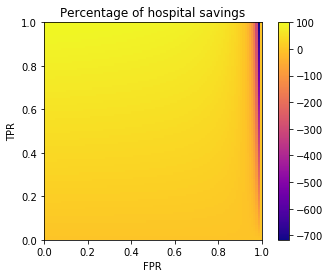

In [3]:
# plot the savings vs TPR,FPR pairs
import matplotlib.pyplot as plt
plt.imshow(hospital_savings,extent=[0,1,0,1], cmap='plasma')
plt.colorbar()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("Percentage of hospital savings")
plt.show()

### We see that at FPR ~1 the saving values become negative, since there are too many incorrect predictions and the FP patient costs add up. At this point, the hospital is better off without any flagging. It is difficult to see what happens for lower FPR values, so I will replot the figure for (FPR<0.9).

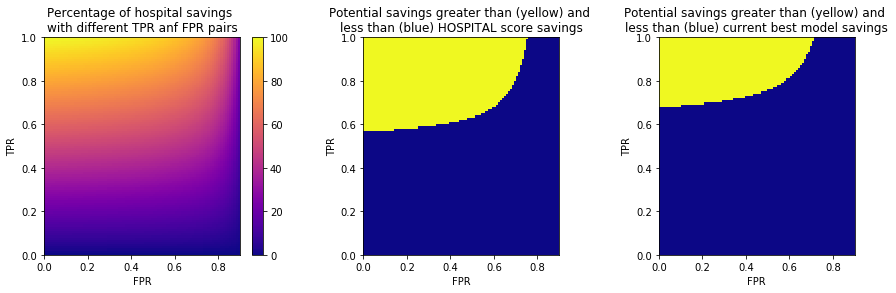

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(hospital_savings[:,:90], extent=[0,0.9,0,1], cmap='plasma')
plt.colorbar()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("Percentage of hospital savings \nwith different TPR anf FPR pairs")

plt.subplot(1, 3, 2)
plt.imshow(hospital_savings>=56.7,extent=[0,0.9,0,1], cmap='plasma')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("Potential savings greater than (yellow) and \nless than (blue) HOSPITAL score savings")
            
plt.subplot(1, 3, 3)
plt.imshow(hospital_savings>=68, extent=[0,0.9,0,1], cmap='plasma')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("Potential savings greater than (yellow) and \nless than (blue) current best model savings")
plt.show()


### Based on this analysis, the current best model yields additional savings and hence is worth adopting!